In [1]:
library(plyr)
library(tidyverse)
library(magrittr)
library(reshape2)
source("../data/env/variables.R")
source("../wisdom/code/r/clean_theme.R")
library(gtools)
library(ggstars)

options("readr.num_columns" = 0)

# Read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor")

# Read feature information
features <- read_tsv("../data/mutations/proteome_features.txt") %>%
    filter(Analysis == "Pfam")

# Read information of the expressed transcripts (TPM>=0.1)
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    mutate(asEvidence=as.numeric(asEvidence=="True"))

# Get statistics per feature
pfam.agg <- features %>%
    # consider splicing information for frequency calculation
    merge(proteome) %>%
    # count at feature level
    group_by(Feature) %>%
    summarize(ProteomeCounts=length(Feature)-sum(!asEvidence),  ## remove cases where no as evidence was found
              TotalLength = sum(FeatureLength)) %>% ## for mutations we apply no filter
    # get expected frequencies
    mutate(ExpectedSwitchFrequency = ProteomeCounts/sum(ProteomeCounts), 
           ExpectedMutFrequency = TotalLength/sum(TotalLength))

# Read structural changes
switches.pfam <- read_tsv('../data/structural_analysis/structural_features.onlyModels.tsv') %>%
    filter(Random=="NonRandom" & Analysis=="Pfam" & WhatsHappenning!="Nothing") %>%
    # Use switch information to characterize structural information
    merge(switches, by=c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript"))

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



## Calculate enrichment in switches

In [2]:
get.uniq.switches <- function(genes,ntxs,ttxs,col,value){
    as.data.frame(cbind(genes,ntxs,ttxs,col)) %>%
        filter(col == value) %>%
        unique %>%
        nrow
}

my.binomial.test <- function(x,testNumber){ 
    if (!is.na(x[1]) & ! is.na(x[2]))
        binom.test(x[1],testNumber,x[2],"greater")$p.value
    else
        NA
}

pfam.switch_info <- switches.pfam %>%
    group_by(Feature) %>%
    summarize(LostNum = sum((WhatsHappenning=="Lost_in_tumor") * PatientNumber), 
              GainNum = sum((WhatsHappenning=="Gained_in_tumor") * PatientNumber), 
              switches_g = get.uniq.switches(GeneId,Normal_transcript,Tumor_transcript,
                                             WhatsHappenning,"Gained_in_tumor"),
              switches_l = get.uniq.switches(GeneId,Normal_transcript,Tumor_transcript, 
                                             WhatsHappenning,"Lost_in_tumor"))

# aggregate switches
totalGains <- sum(pfam.switch_info$GainNum)
totalLosses <- sum(pfam.switch_info$LostNum)

# calculate statistics
pf <- merge(pfam.agg,pfam.switch_info,all=T) %>%
    mutate(fc_g = GainNum/totalGains/ExpectedSwitchFrequency,
           fc_l = LostNum/totalLosses/ExpectedSwitchFrequency) %>%
    mutate(., 
           p_g = apply(subset(.,select=c("GainNum","ExpectedSwitchFrequency")),1,my.binomial.test,totalGains),
           adjp_g = p.adjust(p_g),
           p_l = apply(subset(.,select=c("LostNum","ExpectedSwitchFrequency")),1,my.binomial.test,totalLosses),
           adjp_l = p.adjust(p_l),
           Name = gsub("|","@",Feature,fixed = T),
           Name = gsub("_"," ",Name,fixed = T),
           id = unlist(strsplit(Name,"@"))[c(T,F)], 
           Name = unlist(strsplit(Name,"@"))[c(F,T)])

Let's check the domains that are significantly enriched in switches and that affect more than one switch. The rationale behind the latter criteria is that if a domain is only affected by one switch, we have no-way to ensure it is domain specific rather than gene-specific.

In [3]:
sum(pf$adjp_l<0.05 & pf$switches_l>1,na.rm=T)
sum(pf$adjp_g<0.05 & pf$switches_g>1,na.rm=T)

[1] 233

[1] 54

## Description of the domains

In [4]:
# plot number of domains in each condition
df <- pf

df$Tag <- "Not altered"
df$Tag[df$adjp_g < 0.05 & pf$switches_g>1] <- "Gained"
df$Tag[df$adjp_l < 0.05 & pf$switches_l>1] <- "Lost"
df$Tag[df$adjp_g < 0.05  & pf$switches_g>1 & df$adjp_l < 0.05 & pf$switches_l>1] <- "Both"

table(df$Tag)


       Both      Gained        Lost Not altered 
         13          41         220        5025 

### Comparison to mutations

In [5]:
# Read mutations
allMuts <- c("Frame_Shift_Del","Frame_Shift_Ins","In_Frame_Del","In_Frame_Ins","Missense_Mutation",
             "Nonsense_Mutation","Nonstop_Mutation","Frame_Shift_Del_out","Frame_Shift_Ins_out",
             "Nonsense_Mutation_out")
inFeatureMuts <- c("Frame_Shift_Del","Frame_Shift_Ins","In_Frame_Del","In_Frame_Ins",
                   "Missense_Mutation","Nonsense_Mutation","Nonstop_Mutation")

## calculate total mutations per domain
proteome.muts <- read_tsv("../data/mutations/proteome_mutations.txt") %>%
    filter(Analysis=="Pfam") %>%
    # convert from long format to wide format
    dcast(formula=Feature+Tumor+Transcript~Type, value.var="Patient",fun.aggregate=length) %>%
    group_by(Feature) %>%
    summarise(Frame_Shift_Del = sum(Frame_Shift_Del),
              Frame_Shift_Ins = sum(Frame_Shift_Ins),
              In_Frame_Del = sum(In_Frame_Del),
              In_Frame_Ins = sum(In_Frame_Ins),
              Missense_Mutation = sum(Missense_Mutation),
              Nonsense_Mutation = sum(Nonsense_Mutation),
              Nonstop_Mutation = sum(Nonstop_Mutation),
              Frame_Shift_Del_out = sum(Frame_Shift_Del_out),
              Frame_Shift_Ins_out = sum(Frame_Shift_Ins_out),
              Nonsense_Mutation_out = sum(Nonsense_Mutation_out)) %>%
    mutate(TotalMutations = rowSums(.[,inFeatureMuts]))

# enrichment test
pf.m <- merge(pfam.agg,proteome.muts) %>%
    mutate(fc_m = TotalMutations/sum(TotalMutations)/ExpectedMutFrequency,
           p_m = apply(.[,c("TotalMutations","ExpectedMutFrequency")],1, my.binomial.test, sum(TotalMutations)),
           adjp_m = p.adjust(p_m))

# create table with all the analysis
pf.all <- merge(pf,pf.m,all=T)

# save results
pf.all %>% 
    select(id,Feature,ProteomeCounts,ExpectedSwitchFrequency,LostNum,GainNum,
           fc_g,fc_l,fc_m,p_g,adjp_g,p_l,adjp_l,p_m,adjp_m,switches_g,switches_l) %>%
    write_tsv("../results/pfam_enrichment_analysis.tsv")

In [6]:
sum(pf.m$adjp_m < 0.05)

[1] 76


	Fisher's Exact Test for Count Data

data:  g
p-value = 0.1094
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.947951 1.572503
sample estimates:
odds ratio 
  1.226941 


           Driver
HasMFeature FALSE  TRUE
          0 12937   356
          1  2399    81


	Wilcoxon rank sum test with continuity correction

data:  d$Driver[d$M_feature] and d$Driver[!d$M_feature]
W = 273890, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


Loading required package: RColorBrewer


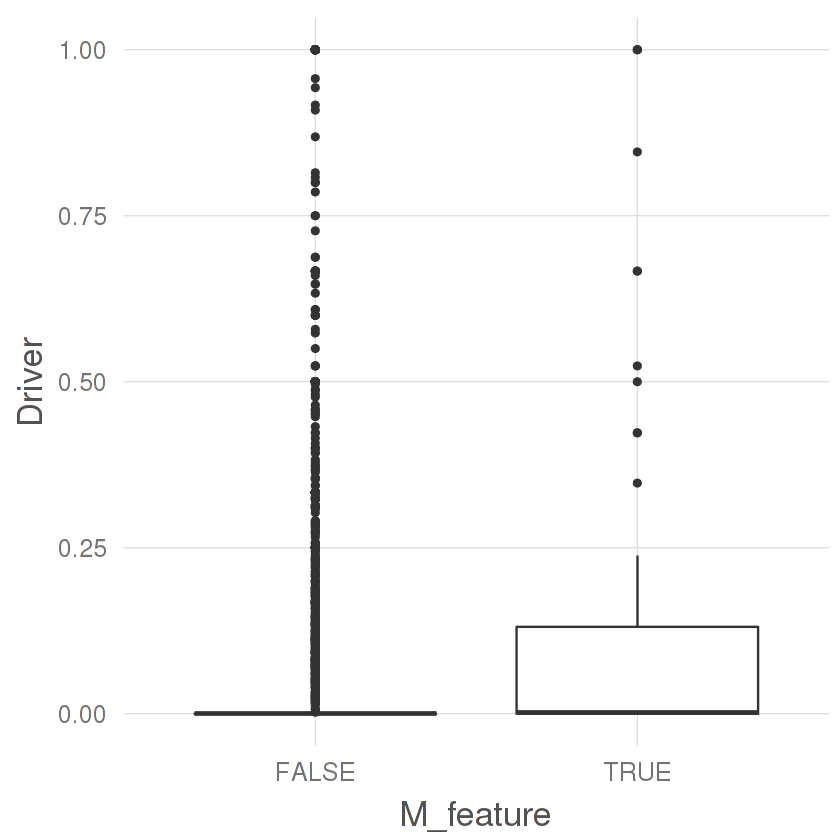

In [7]:
# check if M features have a higher tendency to affect mutational drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
    set_colnames(c("Symbol","Tumor")) %>%
    mutate(Driver=TRUE)

# classify genes based on if they have an M_feature
g <- features %>%
    mutate(M_feature = Feature %in% pf.all$Feature[pf.all$adjp_m < 0.05]) %>%
    group_by(GeneId, Symbol) %>%
    summarise(HasMFeature = max(M_feature)) %>%
    mutate(Driver = Symbol %in% drivers$Symbol) %>%
    ungroup %>%
    select(HasMFeature,Driver) %>%
    table

fisher.test(g)
g

# get the proportion of the domain occurrences that happen in drivers
d <- features %>%
    mutate(Driver = Symbol %in% drivers$Symbol) %>%
    group_by(Feature) %>%
    summarise(Driver = sum(Driver)/n()) %>%
    mutate(M_feature = Feature %in% pf.all$Feature[pf.all$adjp_m < 0.05]) %>%
    select(M_feature,Driver)

wilcox.test(d$Driver[d$M_feature], d$Driver[! d$M_feature])

d %>%
    ggplot(aes(x = M_feature, y = Driver)) +
        geom_boxplot() +
        clean_theme()

In [8]:
M <- pf.all$adjp_m < 0.05
M[is.na(M)] <- FALSE
L <- pf.all$adjp_l < 0.05 & pf.all$switches_l > 1
L[is.na(L)] <- FALSE
G <- pf.all$adjp_g < 0.05 & pf.all$switches_g > 1
G[is.na(G)] <- FALSE
S <- L | G

l <- rep("N", nrow(pf.all))
l[M] <- "M"
l[S] <- "S"
l[M&S] <- "MS"

m <- matrix(table(l),2,2) %>%
    set_colnames(c("M","NM")) %>%
    set_rownames(c("NS","S"))

m <- m[c("S","NS"),c("M","NM")]
fisher.test(m)
m


	Fisher's Exact Test for Count Data

data:  m
p-value = 5.637e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.451696 8.528224
sample estimates:
odds ratio 
  4.710229 


,M,NM
S,15,259
NS,61,4964


There is a higher coincidence than expected by chance. Hence, switches and mutations seem to affect the same protein domains.

In [9]:
# muts + losses
sum(M&L)
# muts + gains
sum(M&G)
# muts + splicing
sum(M&L&G)

[1] 9

[1] 8

[1] 2

In [10]:
# display MS domains
pf.all$Feature[M&S] %>%
    gsub("_"," ",.) %>%
    gsub("PF[0-9]+\\|","",.) %>%
    cbind(pf.all$id[M&S],.) %>%
    set_colnames(c("Id","Name"))

Id,Name
PF00028,Cadherin domain
PF00041,Fibronectin type III domain
PF00071,Ras family
PF00090,Thrombospondin type 1 domain
PF00125,Core histone H2A/H2B/H3/H4
PF00413,Matrixin
PF00683,TB domain
PF00969,"Class II histocompatibility antigen, beta domain"
PF01421,Reprolysin (M12B) family zinc metalloprotease
PF01833,IPT/TIG domain


In [11]:
# genes where MS domains change
features %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    merge(switches,by=c("GeneId","Symbol")) %>%
    arrange(desc(PatientNumber)) %>%
    select(GeneId,Symbol,PatientNumber) %>%
    unique %>%
    head(n=15)

,GeneId,Symbol,PatientNumber
1,345193,LRIT3,134
6,51162,EGFL7,129
17,3371,TNC,115
149,115273,RAB42,89
160,4915,NTRK2,72
182,5879,RAC1,66
194,4238,MFAP3,61
204,345193,LRIT3,54
209,9708,PCDHGA8,54
259,56138,PCDHA11,47


In [12]:
# total number of domains observed
length(unique(c(pfam.agg$Feature,pf$Feature,pf.m$Feature)))

# number of domains for which switch has been observed
sum(pf$LostNum > 0 | pf$GainNum > 0,na.rm=T)

# number of domains for which a mutation has been observed
sum(pf.m$TotalMutations > 0)

[1] 5299

[1] 1453

[1] 5056

### GO term enrichment

```
# gains
awk '$11<0.05 && $16>1' results/pfam_enrichment_analysis.tsv | cut -f1

# losses
awk '$13<0.05 && $17>1' results/pfam_enrichment_analysis.tsv | cut -f1

# gains + losses
awk '($13<0.05 && $17>1) || ($11<0.05 && $16>1)' results/pfam_enrichment_analysis.tsv | cut -f1

# mutated
awk '$15<0.05' results/pfam_enrichment_analysis.tsv | cut -f1

# paste in http://supfam.org/SUPERFAMILY/cgi-bin/dcenrichment.cgi using functions/diseases.
```

### Comparison M - S

The following `from` values were not present in `x`: 4
The following `from` values were not present in `x`: Highly Informative
Warning message:
“Removed 6 rows containing missing values (geom_errorbar).”

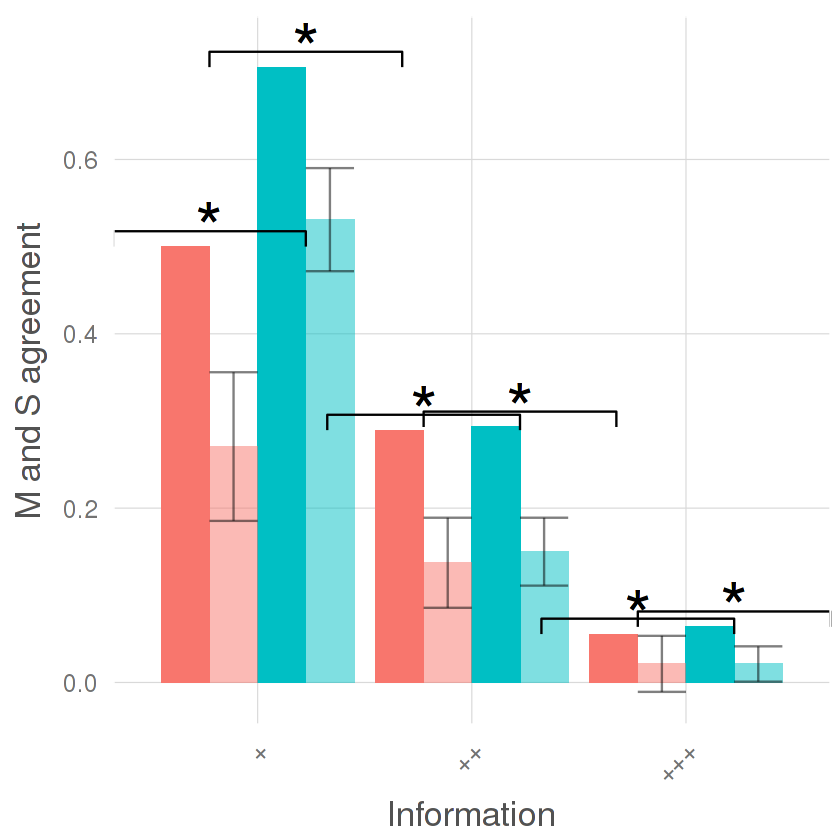

In [13]:
# Read pfam annotation
pfam2go <- read_tsv("../data/PFAM2GO.txt",skip=1)
go.levels <- read_tsv("../data/PFAMGO.txt",skip=1)

pfam2go.m <- merge(pfam2go,go.levels) 

# Get list of all observed domains with their associated annotation
domains <- plyr::dlply(pfam2go.m,.(slim_level,GO_subontology,GO_ID),function(x){
    intersect(pf$id,unlist(strsplit(x[,3],",")))
}) %>% unlist 
class <- gsub("\\.[^\\.]+$","",names(domains))

expressedgos <- unlist(strsplit(names(domains),".",fixed=T))[c(F,F,T)] %>% 
    substr(1,10) %>%
    split(class) %>%
    lapply(unique)

# read GO term enrichment analysis and calculate an agreement between M and S
## molecular function
smf <- read_tsv("../results/pfam_go_term/S_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="switches", gotype="molecular_function")
mmf <- read_tsv("../results/pfam_go_term/M_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="molecular_function")

## cellular component
scc <- read_tsv("../results/pfam_go_term/S_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="switches", gotype="cellular_component")
mcc <- read_tsv("../results/pfam_go_term/M_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="cellular_component")

go <- do.call("rbind",list(smf,mmf,scc,mcc)) %>%
    set_colnames(c("group","id","goterm","slim_level","z","p","fdr","table","domains","origin","gotype")) 

all <- go %>%
    count(id,gotype,slim_level) %>%
    group_by(gotype,slim_level)  %>%
    summarise(Match = sum(n==2), Any=n())

M <- go %>% 
    filter(origin=="mutations") %>%
    count(gotype,slim_level) %>%
    mutate(M = n) %>%
    select(-n)

S <- go %>% 
    filter(origin=="switches") %>%
    count(gotype,slim_level) %>%
    mutate(S = n) %>%
    select(-n)

coincidence <- merge(all,M) %>%
    merge(S) %>%
    mutate(Match = Match/Any, sdMatch = NA, Coincidence = "Observed", 
           slim_level = revalue(as.character(slim_level),
                                replace = c('1'="Least Informative", '2'="Moderately Informative",
                                            '3'="Informative", '4'="Highly Informative")))

# prepare df to get number of samples
M <- unique(coincidence[,c('gotype','slim_level',"M","S")])

random_coincidence <- lapply(names(expressedgos), function(c){
    # select real data comparison
    studied_level <- strsplit(c, "\\.") %>% unlist
    this.slim_level <- studied_level[1]
    this.gotype <- studied_level[2]
    real_match <- coincidence %>% filter(slim_level == this.slim_level & gotype == this.gotype) %>% .$Match
    
    v <- paste(M$slim_level, M$gotype, sep=".") == c
    if (sum(v) > 0){
        x <- M %>% filter(slim_level == this.slim_level & gotype == this.gotype)
        # permutate 100 times
        permutations <- lapply(1:100, function(i){
            m <- sample(expressedgos[[c]],x$M)
            s <- sample(expressedgos[[c]],x$S)
            length(intersect(m,s))/length(unique(c(m,s)))
        }) %>% do.call("c", .)
        f <- ecdf(permutations)

        data.frame(gotype = this.gotype, slim_level = this.slim_level, 
                   Match = mean(permutations), sdMatch = sd(permutations),
                   p = 1 - f(real_match), Coincidence = "Random (x100)")
    }
}) %>% do.call("rbind", .)

p <- random_coincidence$p
        
gg <- coincidence %>%
    select(gotype, slim_level ,Match, sdMatch, Coincidence) %>%
    rbind(random_coincidence %>% select(-p)) %>%
    mutate(slim_level = factor(revalue(slim_level, 
                                       replace = c('Least Informative' = "+", 'Moderately Informative' = "++",
                                                   'Informative' = "+++", 'Highly Informative' = "++++")),
                                       levels = c('+','++','+++','++++')),
           gotype = gsub("_"," ",gotype)) %>%
    ggplot(aes(x = slim_level, y = Match, fill = gotype, alpha = Coincidence)) +
        geom_bar(position = "dodge", stat = "identity") +
        geom_errorbar(aes(ymax = Match + sdMatch, ymin = Match - sdMatch), position = "dodge") +
        scale_alpha_discrete(range = c("Observed" = 1, "Random (x100)" = 0.5)) +
        labs(x = "Information", y = "M and S agreement", fill = "GO Ontology") +
        clean_theme() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

star_bar(gg, p < 0.05)

In [14]:
all <- go %>%
    count(id,gotype,slim_level) %>%
    group_by(gotype,slim_level)  %>%
    summarise(Match = sum(n==2), Any=n())

M <- go %>% 
    filter(origin=="mutations") %>%
    count(gotype,slim_level) %>%
    mutate(M = n) %>%
    select(-n)

S <- go %>% 
    filter(origin=="switches") %>%
    count(gotype,slim_level) %>%
    mutate(S = n) %>%
    select(-n)

In [15]:
# some molecular function terms
x <- table(rbind(mmf[,c(3,4)],smf[,c(3,4)]))
rownames(x)[x[,1]==2]
rownames(x)[x[,2]==2]
rownames(x)[x[,3]==2]

[1] "carbohydrate derivative binding" "cytoskeletal protein binding"   
 [3] "enzyme binding"                  "identical protein binding"      
 [5] "ion binding"                     "macromolecular complex binding" 
 [7] "molecular function regulator"    "protein dimerization activity"  
 [9] "receptor activity"               "receptor binding"               
[11] "signal transducer activity"      "small molecule binding"

[1] "amide binding"                                  
 [2] "beta-catenin binding"                           
 [3] "cargo receptor activity"                        
 [4] "collagen binding"                               
 [5] "cytokine binding"                               
 [6] "endopeptidase activity"                         
 [7] "G-protein coupled receptor activity"            
 [8] "glycosaminoglycan binding"                      
 [9] "growth factor binding"                          
[10] "PDZ domain binding"                             
[11] "protein heterodimerization activity"            
[12] "protein kinase binding"                         
[13] "protein tyrosine kinase activity"               
[14] "RNA polymerase II regulatory region DNA binding"
[15] "serine-type peptidase activity"                 
[16] "sulfur compound binding"                        
[17] "transmembrane receptor protein kinase activity"

[1] "growth factor receptor binding"                
[2] "phosphatidylinositol 3-kinase binding"         
[3] "protein binding involved in cell-cell adhesion"

### Genes containing the domains

We will inquire if gained/lost domains are characteristic of certain either oncogenes or tumor suppressors. We will clasify all the domains present in the reference proteome that occur in oncogenes suppresors as gained or lost (those outside those categories are omited).

In [16]:
L <- pf.all$adjp_l < 0.05 & pf.all$switches_l > 1
L[is.na(L)] <- FALSE
G <- pf.all$adjp_g < 0.05 & pf.all$switches_g > 1
G[is.na(G)] <- FALSE

driver.types <- read_tsv("../data/cancer_networks_SuppTables_v7_S7.csv", col_names = F) %>%
    set_colnames(c("Symbol","Driver_type"))

# gene level: association between oncogenes/tumor suppressors and gained/lost domains
g <- features %>%
    mutate(LFeature = Feature %in% pf.all$Feature[L],
           GFeature = Feature %in% pf.all$Feature[G]) %>%
    merge(driver.types) %>%
    filter(Driver_type %in% c("oncogene","suppressor")) %>%
    group_by(GeneId, Driver_type) %>%
    summarise(ContainsL = max(LFeature)) %>%
    ungroup %>%
    select(-GeneId) %>%
    table

fisher.test(g)
g

g <- features %>%
    mutate(LFeature = Feature %in% pf.all$Feature[L],
           GFeature = Feature %in% pf.all$Feature[G]) %>%
    merge(driver.types) %>%
    filter(Driver_type %in% c("oncogene","suppressor")) %>%
    group_by(GeneId, Driver_type) %>%
    summarise(ContainsG = max(GFeature)) %>%
    ungroup %>%
    select(-GeneId) %>%
    table

fisher.test(g)
g


	Fisher's Exact Test for Count Data

data:  g
p-value = 0.07758
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4008726 1.0479425
sample estimates:
odds ratio 
 0.6540407 


            ContainsL
Driver_type    0   1
  oncogene   244 103
  suppressor 116  32


	Fisher's Exact Test for Count Data

data:  g
p-value = 0.006694
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1836623 0.8020977
sample estimates:
odds ratio 
 0.4007126 


            ContainsG
Driver_type    0   1
  oncogene   289  58
  suppressor 137  11


	Wilcoxon rank sum test with continuity correction

data:  d$Proportion[d$Driver_type == "oncogene" & d$Feature_type ==  and d$Proportion[d$Driver_type == "suppressor" & d$Feature_type ==     "Loss"] and     "Loss"]
W = 3430, p-value = 1.257e-06
alternative hypothesis: true location shift is greater than 0


Warning message in wilcox.test.default(d$Proportion[d$Driver_type == "oncogene" & :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  d$Proportion[d$Driver_type == "oncogene" & d$Feature_type ==  and d$Proportion[d$Driver_type == "suppressor" & d$Feature_type ==     "Gain"] and     "Gain"]
W = 163, p-value = 0.0009293
alternative hypothesis: true location shift is greater than 0


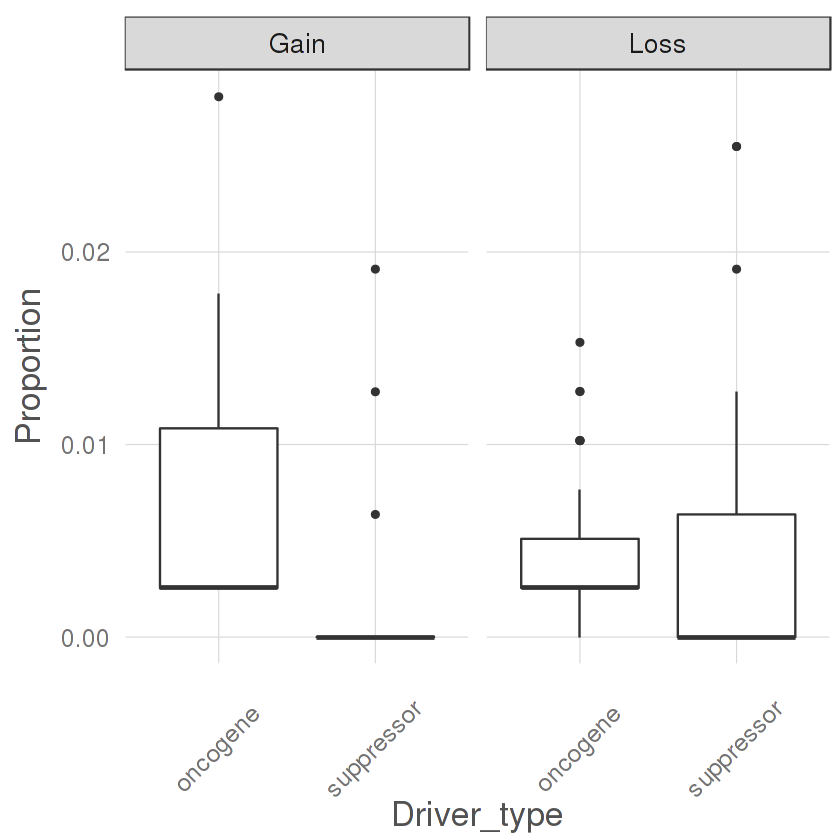

In [17]:
# domain level: association between proportion of the gained/lost domains that affect oncogenes/tumor suppressors
d <- features %>%
    merge(driver.types) %>%
    filter(Driver_type %in% c("oncogene","suppressor")) %>%
    group_by(Feature) %>%
    summarise(oncogene = 
              (GeneId[Driver_type=="oncogene"] %>% unique %>% length)/sum(driver.types$Driver_type=="oncogene"), 
              suppressor = 
              (GeneId[Driver_type=="suppressor"] %>% unique %>% length)/sum(driver.types$Driver_type=="suppressor")) %>%
    reshape2::melt(id.vars = "Feature") %>%
    rename(Driver_type = variable, Proportion = value) %>%
    mutate(Feature_type = ifelse(Feature %in% pf.all$Feature[L], "Loss", "Nothing"),
           Feature_type = ifelse(Feature %in% pf.all$Feature[G], "Gain", Feature_type),
           Feature_type = ifelse(Feature %in% pf.all$Feature[G&L], "Both", Feature_type)) %>%
    filter(Feature_type %in% c("Loss","Gain"))
    
d %>%
    ggplot(aes(x = Driver_type, y = Proportion)) +
        geom_boxplot() +
        clean_theme() +
        facet_grid(. ~ Feature_type) +
        theme(axis.text.x = element_text(angle = 45, vjust = 0.3))

wilcox.test(d$Proportion[d$Driver_type=="oncogene" & d$Feature_type=="Loss"], 
            d$Proportion[d$Driver_type=="suppressor" & d$Feature_type=="Loss"], alternative = "greater")
wilcox.test(d$Proportion[d$Driver_type=="oncogene" & d$Feature_type=="Gain"], 
            d$Proportion[d$Driver_type=="suppressor" & d$Feature_type=="Gain"], alternative = "greater")

In [18]:
# driver type level: association between instances of the gained/lost domains happening in onco/suppressors
t <- features %>%
    merge(driver.types) %>%
    mutate(Feature_type = ifelse(Feature %in% pf.all$Feature[G], "G", "N"),
           Feature_type = ifelse(Feature %in% pf.all$Feature[L], "L", Feature_type)) %>%
    filter(Driver_type %in% c("oncogene","suppressor") & Feature_type %in% c("G","L")) %>%
    select(Driver_type,Feature_type) %>%
    table
   
t %>% fisher.test
t


	Fisher's Exact Test for Count Data

data:  .
p-value = 4.049e-10
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.581475 2.526845
sample estimates:
odds ratio 
  1.990929 


            Feature_type
Driver_type     G    L
  oncogene    663 2674
  suppressor   97  779

## Coincidence in genes
We will check if the domains affected by mutations and switches tend to co-occurr in the same genes.

In [19]:
M <- pf.all$adjp_m < 0.05
M[is.na(M)] <- FALSE
S <- (pf.all$adjp_l < 0.05 & pf.all$switches_l > 1) | (pf.all$adjp_g < 0.05 & pf.all$switches_g > 1)
S[is.na(S)] <- FALSE

# get the genes with a switch involving a MS domain
s.genes <- switches.pfam %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(GeneId,Symbol,Feature) %>%
    unique %>%
    mutate(Switched=TRUE)

# get the genes with a mutation involving a MS domain
m.genes <- read_tsv("../data/mutations/proteome_mutations.txt") %>%
    filter(Analysis=="Pfam") %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(GeneId,Symbol,Feature) %>%
    unique %>%
    mutate(Mutated=TRUE)

# check all genes containing this feature in the proteome
all.genes <- features %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(GeneId,Symbol,Feature) %>%
    unique

# merge to see coincidence between genes
x <- merge(s.genes,m.genes,all=T) %>%
    merge(all.genes,all=T) %>%
    mutate(Switched=ifelse(is.na(Switched),FALSE,TRUE),
           Mutated=ifelse(is.na(Mutated),FALSE,TRUE)) %>%
    group_by(Feature) %>%
    summarise(MS=sum(Mutated&Switched), M=sum(Mutated), 
              S=sum(Switched), N=length(GeneId)) %>%
    mutate(M=M-MS, S=S-MS, 
           N=N-(MS+S+M), J=MS/(M+S+MS)) %>%
    arrange(desc(J))

x

Feature,MS,M,S,N,J
PF00683|TB_domain,3,4,0,0,0.42857143
"PF00969|Class_II_histocompatibility_antigen,_beta_domain",2,3,1,2,0.33333333
PF10409|C2_domain_of_PTEN_tumour-suppressor_protein,2,4,0,1,0.33333333
PF07679|Immunoglobulin_I-set_domain,29,101,5,9,0.21481481
PF00041|Fibronectin_type_III_domain,24,95,4,7,0.19512195
PF07645|Calcium-binding_EGF_domain,12,57,0,2,0.17391304
PF00090|Thrombospondin_type_1_domain,8,39,2,5,0.16326531
PF04103|CD20-like_family,2,12,1,3,0.13333333
PF01833|IPT/TIG_domain,3,19,1,0,0.13043478
PF00413|Matrixin,2,16,0,1,0.11111111


In [20]:
switches.pfam %>%
    filter(Feature=="PF00683|TB_domain") %>%
    select(GeneId,Symbol,WhatsHappenning) %>%
    unique

,GeneId,Symbol,WhatsHappenning
1,4054,LTBP3,Lost_in_tumor
10,8425,LTBP4,Lost_in_tumor
26,2201,FBN2,Lost_in_tumor
